# SVR 是一种用于回归任务的算法，通过在数据中找到一个函数，使得该函数能够尽可能地拟合数据点，同时保持模型的复杂度较低。

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False


In [9]:

# 1. 加载数据集
housing = fetch_california_housing()
X = housing.data  # (20640, 8)
y = housing.target  # 房价中位数
feature_names = housing.feature_names

# 查看数据分布
df = pd.DataFrame(X, columns=feature_names)
df['MedHouseVal'] = y
print(df.describe().round(2))

# 2. 数据预处理
# 标准化（SVR对特征尺度敏感）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. 划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


         MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
count  20640.00  20640.00  20640.00   20640.00    20640.00  20640.00   
mean       3.87     28.64      5.43       1.10     1425.48      3.07   
std        1.90     12.59      2.47       0.47     1132.46     10.39   
min        0.50      1.00      0.85       0.33        3.00      0.69   
25%        2.56     18.00      4.44       1.01      787.00      2.43   
50%        3.53     29.00      5.23       1.05     1166.00      2.82   
75%        4.74     37.00      6.05       1.10     1725.00      3.28   
max       15.00     52.00    141.91      34.07    35682.00   1243.33   

       Latitude  Longitude  MedHouseVal  
count  20640.00   20640.00     20640.00  
mean      35.63    -119.57         2.07  
std        2.14       2.00         1.15  
min       32.54    -124.35         0.15  
25%       33.93    -121.80         1.20  
50%       34.26    -118.49         1.80  
75%       37.71    -118.01         2.65  
max       41.95

In [10]:

# 4. 训练SVR模型
svr_model = SVR(
    kernel='rbf',          # 高斯核函数
    C=1.0,                # 正则化参数
    epsilon=0.1,          # 容忍带宽度（控制对误差的敏感度）
    gamma='scale'         # 核函数系数
)
svr_model.fit(X_train, y_train)

# 5. 模型评估
y_pred = svr_model.predict(X_test)

print("\n评估指标：")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"R²: {r2_score(y_test, y_pred):.3f}")



评估指标：
MSE: 0.355
RMSE: 0.596
R²: 0.729


In [14]:
# 6. 网格搜索模型调优
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(
    estimator=svr_model,
    param_grid={
        'kernel': ['linear', 'rbf'],
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.1]
    },
    scoring='r2',  # 使用r2作为评分指标
    cv=5,  # 5折交叉验证
    verbose=1,  # 输出详细信息
    n_jobs=-1  # 使用所有可用的CPU核心
)
grid_search.fit(X_train, y_train)
print("\n最佳参数：")
print(grid_search.best_params_)
print("\n最佳评分：")
print(grid_search.best_score_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits

最佳参数：
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

最佳评分：
0.7593890979416111


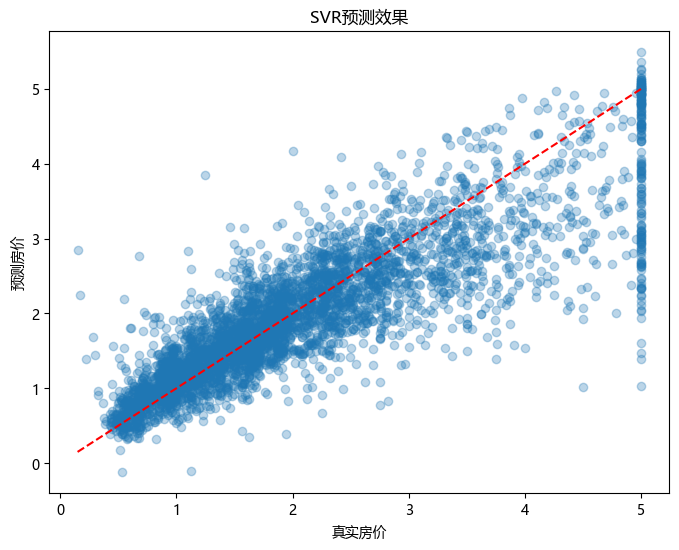

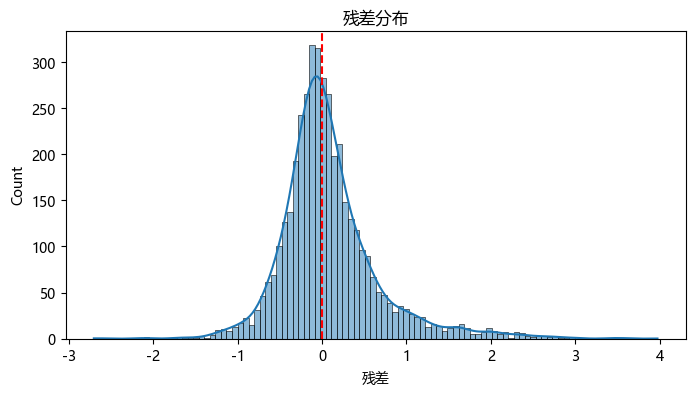

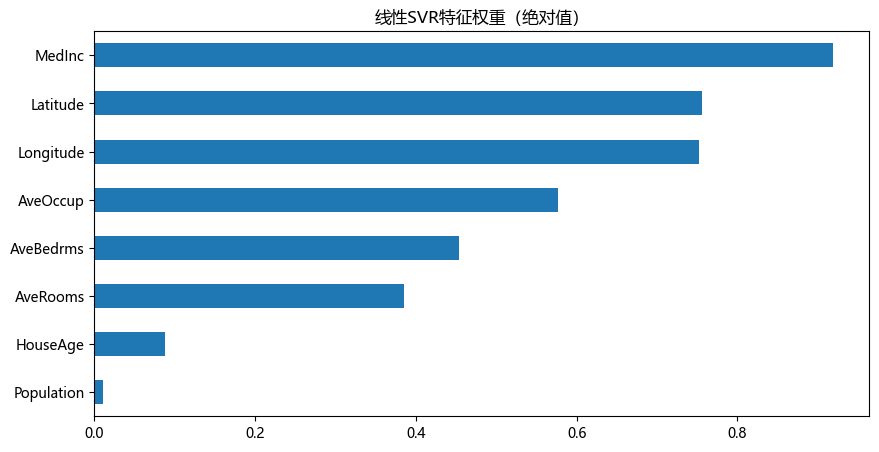

In [15]:

# 6. 可视化结果
# 预测值 vs 真实值散点图
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # 理想线
plt.xlabel("真实房价")
plt.ylabel("预测房价")
plt.title("SVR预测效果")
plt.show()

# 残差分布图
residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True)
plt.axvline(0, color='r', linestyle='--')
plt.xlabel("残差")
plt.title("残差分布")
plt.show()

# 7. 特征重要性分析（需使用线性核）
linear_svr = SVR(kernel='linear').fit(X_train, y_train)
plt.figure(figsize=(10, 5))
coef = pd.Series(linear_svr.coef_[0], index=feature_names)
coef.abs().sort_values().plot(kind='barh')
plt.title("线性SVR特征权重（绝对值）")
plt.show()